In [ ]:
!pip install torch torchvision scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

from sklearn.manifold import TSNE

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

from google.colab import drive
drive.mount('/content/drive')

Using device: cuda
Mounted at /content/drive


In [ ]:
# Define transforms (normalization per CIFAR-10)
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Download CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

100%|██████████| 170M/170M [00:14<00:00, 11.7MB/s]


Train dataset size: 50000
Test dataset size: 10000


In [ ]:
# Define SimCLR Feature Extractor using your current architecture.
class SimCLRModel(nn.Module):
    def __init__(self, base_model=models.resnet18, out_dim=128):
        super(SimCLRModel, self).__init__()
        self.encoder = base_model(weights=None)
        # Modify the first conv layer to a 3x3 kernel (stride=1, padding=1) for CIFAR-10,
        # and remove the maxpool to better preserve spatial resolution.
        self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.encoder.maxpool = nn.Identity()
        self.encoder.fc = nn.Identity()  # Remove final FC layer.
        self.projector = nn.Sequential(nn.Linear(512, 512), nn.ReLU(), nn.Linear(512, out_dim))

    def forward(self, x, return_features=False):
        features = self.encoder(x)
        proj = self.projector(features)
        # When return_features==True, we return the 512D penultimate layer.
        return features if return_features else proj

# ---- New Cell: Load Pretrained SimCLR Model with Specific Key Mapping ----
model_path = "/content/drive/My Drive/MLCW2/simclr_cifar-10.pth.tar"
simclr_model = SimCLRModel()
checkpoint = torch.load(model_path, map_location=device)
new_state_dict = {}
for key, value in checkpoint.items():
    if key.startswith("backbone."):
        new_key = "encoder." + key[len("backbone."):]
    elif key.startswith("contrastive_head."):
        new_key = "projector." + key[len("contrastive_head."):]
    else:
        new_key = key
    if "shortcut" in new_key:
        new_key = new_key.replace("shortcut", "downsample")
    new_state_dict[new_key] = value

simclr_model.load_state_dict(new_state_dict, strict=True)
simclr_modelmodel = simclr_model.to(device)
simclr_model.eval()
print("✅ Pretrained SimCLR model loaded successfully with custom key mapping.")

✅ Pretrained SimCLR model loaded successfully with custom key mapping.


In [ ]:
# Define feature extraction function (using a batch size of 512 for pre-extraction).
def extract_features(dataset, model, batch_size=512, return_features=False):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    all_feats = []
    all_indices = []
    with torch.no_grad():
        for b_idx, (imgs, _) in enumerate(loader):
            imgs = imgs.to(device)
            feats = model(imgs, return_features=return_features)
            all_feats.append(feats.cpu().numpy())
            start = b_idx * batch_size
            end = start + imgs.size(0)
            all_indices.extend(list(range(start, end)))
    all_feats = np.concatenate(all_feats, axis=0)
    return all_feats, all_indices

In [ ]:
# TypiClust query selection using KMeans.
def select_queries(features, indices, budget, n_clusters=None, k_neighbors=20):
    # If not provided, for the first round use budget clusters; later rounds use (|L| + budget) clusters.
    if n_clusters is None:
        n_clusters = budget
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_assignments = kmeans.fit_predict(features)
    query_indices = []
    cluster_info = []
    for cluster_id in np.unique(cluster_assignments):
        mask = (cluster_assignments == cluster_id)
        cluster_features = features[mask]
        cluster_indices = np.array(indices)[mask]
        if len(cluster_features) < 5:
            continue
        K = min(k_neighbors, len(cluster_features))
        nbrs = NearestNeighbors(n_neighbors=K, algorithm='auto').fit(cluster_features)
        distances, _ = nbrs.kneighbors(cluster_features)
        avg_dists = np.mean(distances**2, axis=1)
        typicality = 1.0 / (avg_dists + 1e-8)
        max_typ = np.max(typicality)
        selected_local = np.argmax(typicality)
        selected_index = cluster_indices[selected_local]
        cluster_info.append((cluster_id, max_typ, selected_index))
    # Select the top 'budget' clusters by typicality.
    cluster_info = sorted(cluster_info, key=lambda x: x[1], reverse=True)
    query_indices = [info[2] for info in cluster_info[:budget]]
    return query_indices, cluster_assignments

In [ ]:
def select_queries_random(unlabeled_indices, budget):
    if len(unlabeled_indices) <= budget:
        return unlabeled_indices
    return np.random.choice(unlabeled_indices, size=budget, replace=False).tolist()

In [ ]:
# Set the per-round query budget to 10 (extended setting) to match the paper's reported results.
budget_per_round = 10
full_features_512, full_indices = extract_features(train_dataset, simclr_model, batch_size=512, return_features=True)
query_indices, cluster_labels = select_queries(full_features_512, full_indices, budget=budget_per_round, k_neighbors=20)
print("Selected query indices (TypiClust):", query_indices)

Selected query indices (TypiClust): [np.int64(21951), np.int64(25652), np.int64(35279), np.int64(39958), np.int64(13474), np.int64(2323), np.int64(36712), np.int64(7452), np.int64(3499), np.int64(41205)]


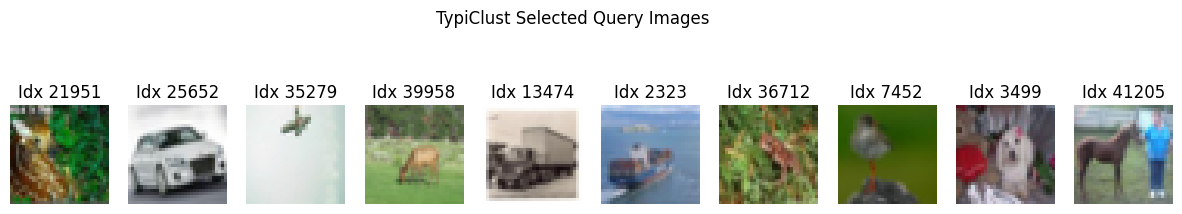

In [ ]:
def plot_selected_images(dataset, query_indices, title="TypiClust Selected Query Images"):
    n = len(query_indices)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(query_indices):
        img, _ = dataset[idx]
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.247, 0.243, 0.261])
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        plt.subplot(1, n, i+1)
        plt.imshow(img_np)
        plt.title(f"Idx {idx}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_selected_images(train_dataset, query_indices)

In [ ]:
# Initialize the labeled set with the initial queries.
labeled_indices = set(query_indices)
labeled_dataset = Subset(train_dataset, list(labeled_indices))
labeled_loader = DataLoader(labeled_dataset, batch_size=budget_per_round, shuffle=True, num_workers=2)

In [ ]:
# (i) Fully Supervised Evaluation:
def evaluate_fs(labeled_indices, train_dataset, test_loader, epochs=100, batch_size=10):
    subset = Subset(train_dataset, list(labeled_indices))
    loader = DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2)

    class SimpleCNN(nn.Module):
        def __init__(self, num_classes=10):
            super(SimpleCNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
            self.classifier = nn.Sequential(
                nn.Linear(64*8*8, 128),
                nn.ReLU(),
                nn.Linear(128, num_classes)
            )
        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            return self.classifier(x)

    model = SimpleCNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9, nesterov=True)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    model.train()
    for ep in range(epochs):
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100.0 * correct / total

In [ ]:
# (ii) Fully Supervised with Self-Supervised Embeddings (Linear Classifier)
def evaluate_lin(labeled_indices, train_dataset, test_dataset, epochs=100, batch_size=10):
    subset = Subset(train_dataset, list(labeled_indices))
    # Extract 512D features using the encoder with batch_size=10.
    feats_l, _ = extract_features(subset, simclr_model, batch_size=10, return_features=True)
    feats_l = feats_l / np.linalg.norm(feats_l, axis=1, keepdims=True)
    targets_l = np.array([train_dataset[i][1] for i in list(labeled_indices)])

    feats_test, _ = extract_features(test_dataset, simclr_model, batch_size=128, return_features=True)
    feats_test = feats_test / np.linalg.norm(feats_test, axis=1, keepdims=True)
    targets_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])

    class LinearClassifier(nn.Module):
        def __init__(self, in_dim, num_classes=10):
            super(LinearClassifier, self).__init__()
            self.fc = nn.Linear(in_dim, num_classes)
        def forward(self, x):
            return self.fc(x)

    input_dim = feats_l.shape[1]
    model = LinearClassifier(input_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=2.5, momentum=0.9)

    train_ds = TensorDataset(torch.tensor(feats_l, dtype=torch.float32),
                             torch.tensor(targets_l, dtype=torch.long))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_ds = TensorDataset(torch.tensor(feats_test, dtype=torch.float32),
                            torch.tensor(targets_test, dtype=torch.long))
    test_loader_ = DataLoader(test_ds, batch_size=128, shuffle=False)

    model.train()
    for ep in range(epochs):
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in test_loader_:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb).argmax(dim=1)
            total += yb.size(0)
            correct += (preds == yb).sum().item()
    return 100.0 * correct / total

In [ ]:
# (iii) Semi-Supervised Evaluation (Simplified Pseudo-Labeling)
def evaluate_ssl(labeled_indices, train_dataset, test_loader, epochs=100, threshold=0.95, batch_size=10):
    labeled_subset = Subset(train_dataset, list(labeled_indices))
    labeled_loader = DataLoader(labeled_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    all_idx = set(range(len(train_dataset)))
    unlabeled_idx = list(all_idx - set(labeled_indices))
    unlabeled_subset = Subset(train_dataset, unlabeled_idx)
    unlabeled_loader = DataLoader(unlabeled_subset, batch_size=64, shuffle=True, num_workers=2)

    class SemiSupervisedCNN(nn.Module):
        def __init__(self, num_classes=10):
            super(SemiSupervisedCNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
            self.classifier = nn.Sequential(
                nn.Linear(64*8*8, 128),
                nn.ReLU(),
                nn.Linear(128, num_classes)
            )
        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            return self.classifier(x)

    model = SemiSupervisedCNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0005)

    model.train()
    for ep in range(epochs):
        # Use a sigmoid ramp-up for the unsupervised weight.
        unsup_weight = float(1.0 / (1.0 + np.exp(-5*(ep/epochs - 0.5))))
        unl_iter = iter(unlabeled_loader)
        for inputs_l, labels_l in labeled_loader:
            inputs_l, labels_l = inputs_l.to(device), labels_l.to(device)
            sup_out = model(inputs_l)
            sup_loss = criterion(sup_out, labels_l)
            try:
                inputs_u, _ = next(unl_iter)
            except StopIteration:
                unl_iter = iter(unlabeled_loader)
                inputs_u, _ = next(unl_iter)
            inputs_u = inputs_u.to(device)
            with torch.no_grad():
                out_u = model(inputs_u)
                probs_u = torch.softmax(out_u, dim=1)
                max_probs, pseudo_labels = torch.max(probs_u, dim=1)
            mask = (max_probs >= threshold).float()
            if mask.sum() > 0:
                out_u2 = model(inputs_u)
                unsup_loss = (criterion(out_u2, pseudo_labels) * mask).mean()
            else:
                unsup_loss = torch.tensor(0.0).to(device)
            total_loss = sup_loss + unsup_weight * unsup_loss
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100.0 * correct / total

In [ ]:
num_repetitions = 10  # For averaging (as in the paper)
num_rounds = 5        # 5 AL rounds per repetition

In [ ]:
# Fully Supervised Evaluation (FS)
# Hyperparameters per paper: ResNet18 trained from scratch,
# using SGD (lr=0.025, momentum=0.9, nesterov=True) with cosine LR scheduling.
# In the low-budget regime, the batch size for training is set to 10.

all_TPC_FS = np.zeros((num_repetitions, num_rounds))
all_RAND_FS = np.zeros((num_repetitions, num_rounds))

for rep in range(num_repetitions):
    print(f"\n=== FS Repetition {rep+1}/{num_repetitions} ===")
    # Re-extract features for initial pool selection using batch_size=512.
    full_features_512, full_indices = extract_features(train_dataset, simclr_model, batch_size=512, return_features=True)
    all_idx = set(range(len(train_dataset)))

    # Initial pool selection (Budget = budget_per_round)
    init_tpc, _ = select_queries(full_features_512, full_indices, budget=budget_per_round, k_neighbors=20)
    init_rand = select_queries_random(list(all_idx), budget=budget_per_round)

    labeled_indices_tpc = set(init_tpc)
    labeled_indices_rand = set(init_rand)

    for r in range(num_rounds):
        print(f"\n--- FS Repetition {rep+1}, AL Round {r+1} ---")
        tpc_fs = evaluate_fs(labeled_indices_tpc, train_dataset, test_loader, epochs=100, batch_size=10)
        rand_fs = evaluate_fs(labeled_indices_rand, train_dataset, test_loader, epochs=100, batch_size=10)
        print(f"[TPC] FS: {tpc_fs:.2f}%")
        print(f"[RANDOM] FS: {rand_fs:.2f}%")

        all_TPC_FS[rep, r] = tpc_fs
        all_RAND_FS[rep, r] = rand_fs

        # Update labeled sets for FS evaluation using same query selection strategy:
        unlabeled_tpc = list(all_idx - labeled_indices_tpc)
        if len(unlabeled_tpc) < budget_per_round:
            print("Not enough unlabeled samples for TPC. Stopping rounds.")
            break
        unlabeled_subset_tpc = Subset(train_dataset, unlabeled_tpc)
        unlabeled_feats, unlabeled_idx_rel = extract_features(unlabeled_subset_tpc, simclr_model, batch_size=128, return_features=True)
        n_clusters = len(labeled_indices_tpc) + budget_per_round  # as per paper: |L|+B
        new_tpc, _ = select_queries(unlabeled_feats, unlabeled_idx_rel, budget=budget_per_round, n_clusters=n_clusters, k_neighbors=20)
        new_tpc_orig = [unlabeled_tpc[i] for i in new_tpc]
        print(" [TPC] New FS queries selected:", new_tpc_orig)
        labeled_indices_tpc.update(new_tpc_orig)

        unlabeled_rand = list(all_idx - labeled_indices_rand)
        if len(unlabeled_rand) < budget_per_round:
            print("Not enough unlabeled samples for RANDOM. Stopping rounds.")
            break
        new_rand = select_queries_random(unlabeled_rand, budget=budget_per_round)
        print(" [RANDOM] New FS queries selected:", new_rand)
        labeled_indices_rand.update(new_rand)

    print(f"\n=== FS Repetition {rep+1} Completed ===\n")

avg_TPC_FS = all_TPC_FS.mean(axis=0)
avg_RAND_FS = all_RAND_FS.mean(axis=0)
print("Averaged TPC Fully Supervised Accuracies per Round:", avg_TPC_FS)
print("Averaged RANDOM Fully Supervised Accuracies per Round:", avg_RAND_FS)
print("\n=== Final Overall FS Averages ===")
print(f"Final TPC Fully Supervised: {all_TPC_FS.mean():.2f}%")
print(f"Final RANDOM Fully Supervised: {all_RAND_FS.mean():.2f}%")


=== FS Repetition 1/10 ===

--- FS Repetition 1, AL Round 1 ---
[TPC] FS: 18.14%
[RANDOM] FS: 16.59%
 [TPC] New FS queries selected: [31733, 11196, 35279, 15330, 21636, 2172, 15527, 12846, 23560, 16656]
 [RANDOM] New FS queries selected: [33121, 21564, 39051, 8165, 31049, 47483, 18360, 38237, 13870, 2681]

--- FS Repetition 1, AL Round 2 ---
[TPC] FS: 21.48%
[RANDOM] FS: 16.56%
 [TPC] New FS queries selected: [18627, 30570, 22346, 27571, 33247, 6717, 13474, 16619, 47902, 27391]
 [RANDOM] New FS queries selected: [3264, 3584, 12878, 41780, 30217, 21055, 24453, 49230, 13489, 121]

--- FS Repetition 1, AL Round 3 ---
[TPC] FS: 20.08%
[RANDOM] FS: 21.50%
 [TPC] New FS queries selected: [3775, 1681, 1329, 49994, 19984, 40265, 32483, 47196, 31612, 8952]
 [RANDOM] New FS queries selected: [1607, 16351, 42962, 36953, 44918, 35335, 44654, 10919, 35559, 37268]

--- FS Repetition 1, AL Round 4 ---
[TPC] FS: 21.03%
[RANDOM] FS: 20.04%
 [TPC] New FS queries selected: [25569, 19920, 7774, 29632, 52

In [ ]:
# Fully Supervised with Self-Supervised Embeddings (Linear Evaluation)
# In this framework, we train a single linear classifier on L2-normalized 512D embeddings.
# Per the paper, we increase the initial learning rate by a factor of 100 to 2.5 and double the epochs.

all_TPC_LIN = np.zeros((num_repetitions, num_rounds))
all_RAND_LIN = np.zeros((num_repetitions, num_rounds))

for rep in range(num_repetitions):
    print(f"\n=== LIN Repetition {rep+1}/{num_repetitions} ===")
    full_features_512, full_indices = extract_features(train_dataset, simclr_model, batch_size=512, return_features=True)
    all_idx = set(range(len(train_dataset)))

    init_tpc, _ = select_queries(full_features_512, full_indices, budget=budget_per_round, k_neighbors=20)
    init_rand = select_queries_random(list(all_idx), budget=budget_per_round)

    labeled_indices_tpc = set(init_tpc)
    labeled_indices_rand = set(init_rand)

    for r in range(num_rounds):
        print(f"\n--- LIN Repetition {rep+1}, AL Round {r+1} ---")
        tpc_lin = evaluate_lin(labeled_indices_tpc, train_dataset, test_dataset, epochs=100, batch_size=10)
        rand_lin = evaluate_lin(labeled_indices_rand, train_dataset, test_dataset, epochs=100, batch_size=10)
        print(f"[TPC] LIN: {tpc_lin:.2f}%")
        print(f"[RANDOM] LIN: {rand_lin:.2f}%")

        all_TPC_LIN[rep, r] = tpc_lin
        all_RAND_LIN[rep, r] = rand_lin

        # Update labeled sets (using same strategy as before)
        unlabeled_tpc = list(all_idx - labeled_indices_tpc)
        if len(unlabeled_tpc) < budget_per_round:
            print("Not enough unlabeled samples for TPC. Stopping rounds.")
            break
        unlabeled_subset_tpc = Subset(train_dataset, unlabeled_tpc)
        unlabeled_feats, unlabeled_idx_rel = extract_features(unlabeled_subset_tpc, simclr_model, batch_size=128, return_features=True)
        n_clusters = len(labeled_indices_tpc) + budget_per_round
        new_tpc, _ = select_queries(unlabeled_feats, unlabeled_idx_rel, budget=budget_per_round, n_clusters=n_clusters, k_neighbors=20)
        new_tpc_orig = [unlabeled_tpc[i] for i in new_tpc]
        print(" [TPC] New LIN queries selected:", new_tpc_orig)
        labeled_indices_tpc.update(new_tpc_orig)

        unlabeled_rand = list(all_idx - labeled_indices_rand)
        if len(unlabeled_rand) < budget_per_round:
            print("Not enough unlabeled samples for RANDOM. Stopping rounds.")
            break
        new_rand = select_queries_random(unlabeled_rand, budget=budget_per_round)
        print(" [RANDOM] New LIN queries selected:", new_rand)
        labeled_indices_rand.update(new_rand)

    print(f"\n=== LIN Repetition {rep+1} Completed ===\n")

avg_TPC_LIN = all_TPC_LIN.mean(axis=0)
avg_RAND_LIN = all_RAND_LIN.mean(axis=0)
print("Averaged TPC Linear Accuracies per Round:", avg_TPC_LIN)
print("Averaged RANDOM Linear Accuracies per Round:", avg_RAND_LIN)
print("\n=== Final Overall Linear Averages ===")
print(f"Final TPC Linear: {all_TPC_LIN.mean():.2f}%")
print(f"Final RANDOM Linear: {all_RAND_LIN.mean():.2f}%")


=== LIN Repetition 1/10 ===

--- LIN Repetition 1, AL Round 1 ---
[TPC] LIN: 48.45%
[RANDOM] LIN: 51.55%
 [TPC] New LIN queries selected: [31733, 11196, 28178, 6646, 16, 4710, 46809, 32675, 14248, 23560]
 [RANDOM] New LIN queries selected: [46886, 3300, 39183, 35507, 39068, 31599, 3351, 49305, 36176, 28788]

--- LIN Repetition 1, AL Round 2 ---
[TPC] LIN: 62.60%
[RANDOM] LIN: 53.84%
 [TPC] New LIN queries selected: [18627, 30570, 33247, 27571, 40158, 2172, 47902, 23017, 35740, 38686]
 [RANDOM] New LIN queries selected: [33739, 44846, 41874, 33392, 33478, 9448, 14290, 21597, 20334, 10827]

--- LIN Repetition 1, AL Round 3 ---
[TPC] LIN: 61.68%
[RANDOM] LIN: 57.99%
 [TPC] New LIN queries selected: [3775, 1681, 15330, 36188, 49994, 27931, 40265, 16674, 6717, 12190]
 [RANDOM] New LIN queries selected: [37747, 9801, 31447, 5167, 28807, 6399, 35570, 11535, 15178, 3187]

--- LIN Repetition 1, AL Round 4 ---
[TPC] LIN: 60.01%
[RANDOM] LIN: 63.37%
 [TPC] New LIN queries selected: [25569, 19920

In [ ]:
# Semi-Supervised Evaluation (SSL) with Simplified Pseudo-Labeling
# For CIFAR-10, per the paper, use batch size of 64 for unlabeled data.
# The optimizer is set with lr=0.03, momentum=0.9, weight_decay=0.0005 for CIFAR-10.

all_TPC_SSL = np.zeros((num_repetitions, num_rounds))
all_RAND_SSL = np.zeros((num_repetitions, num_rounds))

for rep in range(num_repetitions):
    print(f"\n=== SSL Repetition {rep+1}/{num_repetitions} ===")
    full_features_512, full_indices = extract_features(train_dataset, simclr_model, batch_size=512, return_features=True)
    all_idx = set(range(len(train_dataset)))

    init_tpc, _ = select_queries(full_features_512, full_indices, budget=budget_per_round, k_neighbors=20)
    init_rand = select_queries_random(list(all_idx), budget=budget_per_round)

    labeled_indices_tpc = set(init_tpc)
    labeled_indices_rand = set(init_rand)

    for r in range(num_rounds):
        print(f"\n--- SSL Repetition {rep+1}, AL Round {r+1} ---")
        tpc_ssl = evaluate_ssl(labeled_indices_tpc, train_dataset, test_loader, epochs=100, threshold=0.95, batch_size=10)
        rand_ssl = evaluate_ssl(labeled_indices_rand, train_dataset, test_loader, epochs=100, threshold=0.95, batch_size=10)
        print(f"[TPC] SSL: {tpc_ssl:.2f}%")
        print(f"[RANDOM] SSL: {rand_ssl:.2f}%")

        all_TPC_SSL[rep, r] = tpc_ssl
        all_RAND_SSL[rep, r] = rand_ssl

        # Update labeled sets using same query selection strategy
        unlabeled_tpc = list(all_idx - labeled_indices_tpc)
        if len(unlabeled_tpc) < budget_per_round:
            print("Not enough unlabeled samples for TPC. Stopping rounds.")
            break
        unlabeled_subset_tpc = Subset(train_dataset, unlabeled_tpc)
        unlabeled_feats, unlabeled_idx_rel = extract_features(unlabeled_subset_tpc, simclr_model, batch_size=128, return_features=True)
        n_clusters = len(labeled_indices_tpc) + budget_per_round
        new_tpc, _ = select_queries(unlabeled_feats, unlabeled_idx_rel, budget=budget_per_round, n_clusters=n_clusters, k_neighbors=20)
        new_tpc_orig = [unlabeled_tpc[i] for i in new_tpc]
        print(" [TPC] New SSL queries selected:", new_tpc_orig)
        labeled_indices_tpc.update(new_tpc_orig)

        unlabeled_rand = list(all_idx - labeled_indices_rand)
        if len(unlabeled_rand) < budget_per_round:
            print("Not enough unlabeled samples for RANDOM. Stopping rounds.")
            break
        new_rand = select_queries_random(unlabeled_rand, budget=budget_per_round)
        print(" [RANDOM] New SSL queries selected:", new_rand)
        labeled_indices_rand.update(new_rand)

    print(f"\n=== SSL Repetition {rep+1} Completed ===\n")

avg_TPC_SSL = all_TPC_SSL.mean(axis=0)
avg_RAND_SSL = all_RAND_SSL.mean(axis=0)
print("Averaged TPC SSL Accuracies per Round:", avg_TPC_SSL)
print("Averaged RANDOM SSL Accuracies per Round:", avg_RAND_SSL)
print("\n=== Final Overall SSL Averages ===")
print(f"Final TPC SSL: {all_TPC_SSL.mean():.2f}%")
print(f"Final RANDOM SSL: {all_RAND_SSL.mean():.2f}%")


=== SSL Repetition 1/10 ===

--- SSL Repetition 1, AL Round 1 ---
[TPC] SSL: 15.03%
[RANDOM] SSL: 13.04%
 [TPC] New SSL queries selected: [31733, 11196, 28178, 33247, 2172, 13247, 5639, 39063, 13966, 23560]
 [RANDOM] New SSL queries selected: [29512, 20430, 44124, 45932, 11707, 34357, 16074, 26624, 48792, 47895]

--- SSL Repetition 1, AL Round 2 ---
[TPC] SSL: 15.10%
[RANDOM] SSL: 16.74%
 [TPC] New SSL queries selected: [18627, 30570, 36188, 27571, 31612, 40158, 8952, 16619, 45777, 46809]
 [RANDOM] New SSL queries selected: [3398, 16608, 3033, 49165, 37715, 31691, 3519, 6121, 8798, 12449]

--- SSL Repetition 1, AL Round 3 ---
[TPC] SSL: 19.65%
[RANDOM] SSL: 16.84%
 [TPC] New SSL queries selected: [3775, 1681, 15330, 6332, 27931, 32919, 21636, 34842, 6717, 42252]
 [RANDOM] New SSL queries selected: [25180, 3390, 32691, 46073, 21877, 16430, 47264, 40627, 18291, 37645]

--- SSL Repetition 1, AL Round 4 ---
[TPC] SSL: 19.76%
[RANDOM] SSL: 15.96%
 [TPC] New SSL queries selected: [25569, 77

In [ ]:
print("avg_TPC_FS:", avg_TPC_FS)
print("avg_RAND_FS:", avg_RAND_FS)
print("avg_TPC_LIN:", avg_TPC_LIN)
print("avg_RAND_LIN:", avg_RAND_LIN)
print("avg_TPC_SSL:", avg_TPC_SSL)
print("avg_RAND_SSL:", avg_RAND_SSL)

avg_TPC_FS: [17.539 20.74  21.208 20.801 20.194]
avg_RAND_FS: [16.37  17.672 20.548 20.479 20.874]
avg_TPC_LIN: [52.763 60.738 62.38  63.087 63.832]
avg_RAND_LIN: [39.578 50.109 58.134 65.263 68.716]
avg_TPC_SSL: [14.832 17.281 17.737 18.795 18.754]
avg_RAND_SSL: [12.164 15.574 16.759 17.818 17.732]


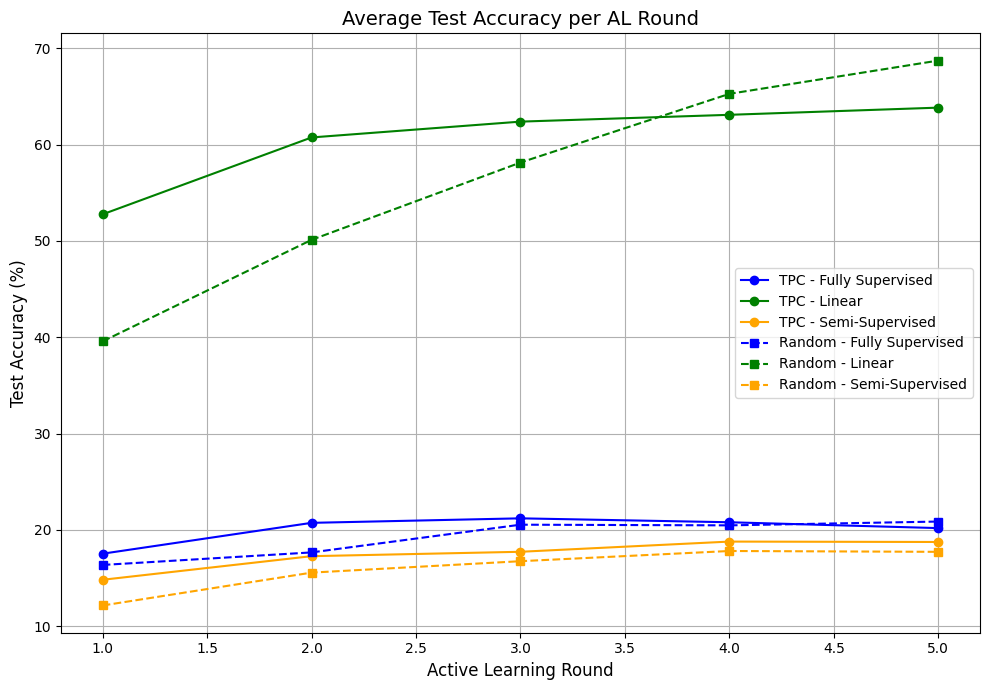

In [ ]:

# Plot overall performance clearly with distinctive line styles
plt.figure(figsize=(10, 7))
rounds = range(1, num_rounds + 1)

# TPC methods (solid lines)
plt.plot(rounds, avg_TPC_FS, marker='o', linestyle='-', color='blue', label="TPC - Fully Supervised")
plt.plot(rounds, avg_TPC_LIN, marker='o', linestyle='-', color='green', label="TPC - Linear")
plt.plot(rounds, avg_TPC_SSL, marker='o', linestyle='-', color='orange', label="TPC - Semi-Supervised")

# RANDOM methods (dashed lines)
plt.plot(rounds, avg_RAND_FS, marker='s', linestyle='--', color='blue', label="Random - Fully Supervised")
plt.plot(rounds, avg_RAND_LIN, marker='s', linestyle='--', color='green', label="Random - Linear")
plt.plot(rounds, avg_RAND_SSL, marker='s', linestyle='--', color='orange', label="Random - Semi-Supervised")

# Labels and title
plt.xlabel("Active Learning Round", fontsize=12)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.title("Average Test Accuracy per AL Round", fontsize=14)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

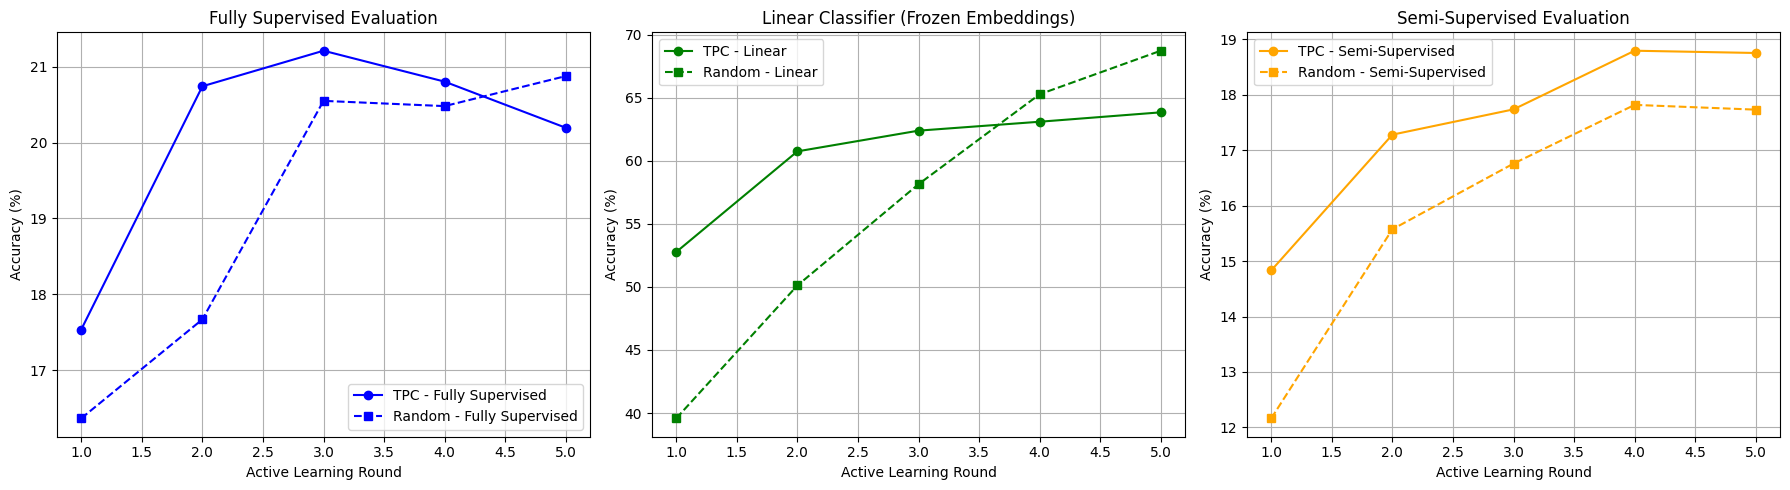

In [ ]:
plt.figure(figsize=(18, 5))

# Fully Supervised
plt.subplot(1, 3, 1)
plt.plot(rounds, avg_TPC_FS, marker='o', linestyle='-', color='blue', label="TPC - Fully Supervised")
plt.plot(rounds, avg_RAND_FS, marker='s', linestyle='--', color='blue', label="Random - Fully Supervised")
plt.title("Fully Supervised Evaluation")
plt.xlabel("Active Learning Round")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Linear
plt.subplot(1, 3, 2)
plt.plot(rounds, avg_TPC_LIN, marker='o', linestyle='-', color='green', label="TPC - Linear")
plt.plot(rounds, avg_RAND_LIN, marker='s', linestyle='--', color='green', label="Random - Linear")
plt.title("Linear Classifier (Frozen Embeddings)")
plt.xlabel("Active Learning Round")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Semi-Supervised
plt.subplot(1, 3, 3)
plt.plot(rounds, avg_TPC_SSL, marker='o', linestyle='-', color='orange', label="TPC - Semi-Supervised")
plt.plot(rounds, avg_RAND_SSL, marker='s', linestyle='--', color='orange', label="Random - Semi-Supervised")
plt.title("Semi-Supervised Evaluation")
plt.xlabel("Active Learning Round")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

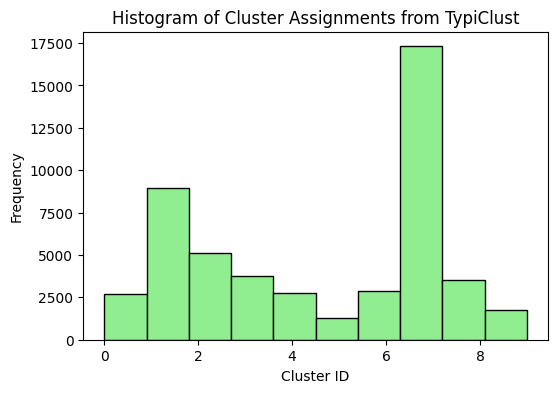

In [ ]:
# Additional EDA: Histogram of cluster assignments.
plt.figure(figsize=(6,4))
plt.hist(cluster_labels, bins=budget_per_round, color='lightgreen', edgecolor='black')
plt.xlabel("Cluster ID")
plt.ylabel("Frequency")
plt.title("Histogram of Cluster Assignments from TypiClust")
plt.show()

Running linear probe on embeddings:


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


🔍 Linear classifier accuracy: 89.25%
Visualizing embeddings using t-SNE and clustering:


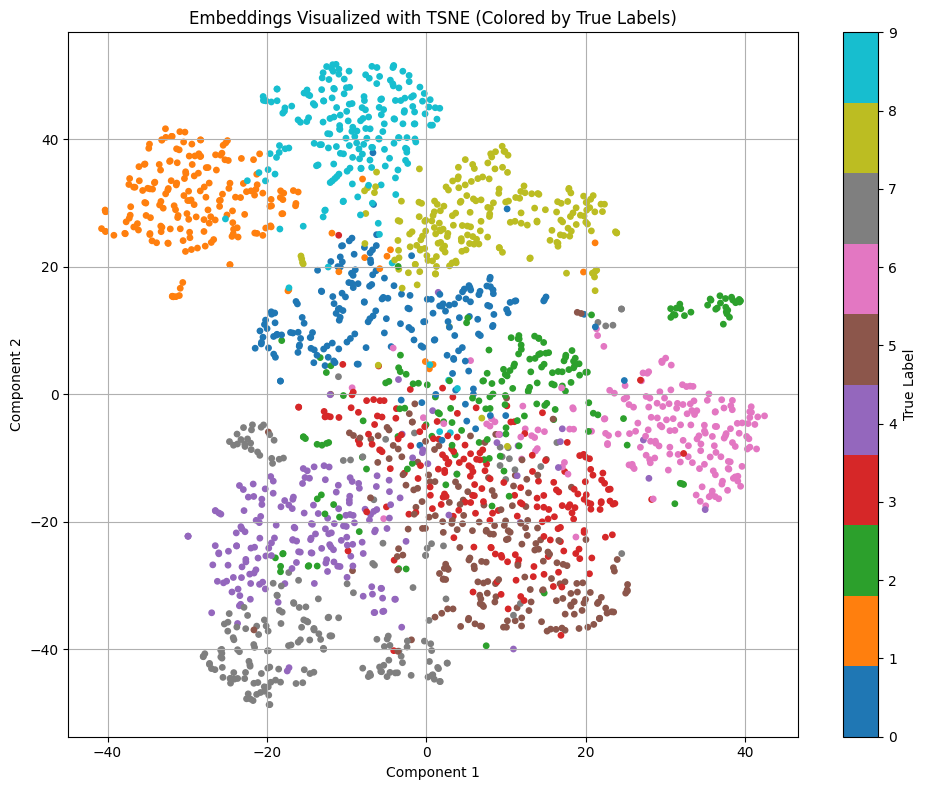

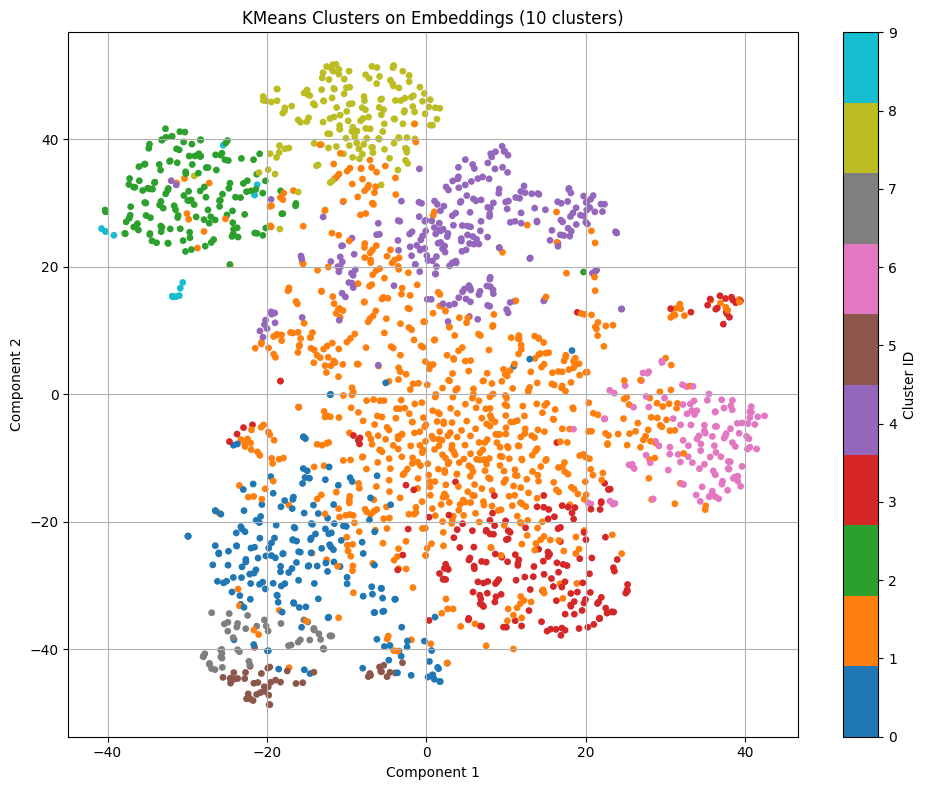

In [ ]:
# Cell: Evaluate and Visualize Embeddings

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def linear_probe(embeddings, labels):
    """Train a logistic regression classifier on the embeddings and report accuracy."""
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42, stratify=labels
    )
    clf = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"🔍 Linear classifier accuracy: {acc*100:.2f}%")
    return acc

def visualize_embedding_clusters(embeddings, labels, method='tsne', sample_size=2000, n_clusters=10):
    """
    Visualize clustering of embeddings using t-SNE or PCA.
    Args:
        embeddings (np.ndarray): Embeddings from the SimCLR model.
        labels (np.ndarray): True CIFAR-10 labels.
        method (str): 'tsne' or 'pca'
        sample_size (int): Number of samples to plot.
        n_clusters (int): Number of clusters for KMeans.
    """
    assert method in ['tsne', 'pca'], "Method must be 'tsne' or 'pca'."
    np.random.seed(42)
    indices = np.random.choice(len(embeddings), size=sample_size, replace=False)
    emb_subset = embeddings[indices]
    labels_subset = labels[indices]

    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:
        reducer = PCA(n_components=2)

    reduced_embs = reducer.fit_transform(emb_subset)

    # Apply KMeans clustering to the subsampled embeddings.
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_ids = kmeans.fit_predict(emb_subset)

    # Plot: Colored by true labels.
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embs[:, 0], reduced_embs[:, 1], c=labels_subset, cmap='tab10', s=15)
    plt.title(f"Embeddings Visualized with {method.upper()} (Colored by True Labels)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(scatter, ticks=range(10), label='True Label')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot: Colored by KMeans cluster assignments.
    plt.figure(figsize=(10, 8))
    scatter2 = plt.scatter(reduced_embs[:, 0], reduced_embs[:, 1], c=cluster_ids, cmap='tab10', s=15)
    plt.title(f"KMeans Clusters on Embeddings ({n_clusters} clusters)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(scatter2, ticks=range(n_clusters), label='Cluster ID')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Extract embeddings for the entire training set (or a subset for faster computation)
embeddings, indices = extract_features(train_dataset, simclr_model, batch_size=512, return_features=True)
labels = np.array([train_dataset[i][1] for i in range(len(train_dataset))])

print("Running linear probe on embeddings:")
linear_probe(embeddings, labels)

print("Visualizing embeddings using t-SNE and clustering:")
visualize_embedding_clusters(embeddings, labels, method='tsne', sample_size=2000, n_clusters=10)